In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.2


# 유틸

In [2]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [3]:
def load_model(model_name: str, with_weights_path: Optional[str] = None) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

In [4]:
import os
base_gdrive_path = os.path.join("drive", "MyDrive", "lecture_220711")

In [5]:
result_path = os.path.join(base_gdrive_path, "results")

# Dataset

## 다운로드

In [6]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [7]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [8]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHV04SH/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## 살펴보기

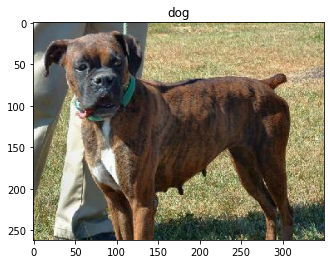

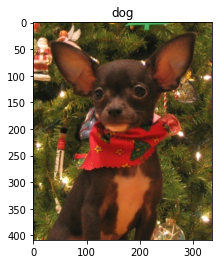

In [9]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

## 데이터 포맷

In [10]:
IMG_SIZE = 224 # 모든 이미지는 224x224로 크기가 조정됩니다

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255.0)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

  label = tf.cast(label, tf.float32)
  return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [13]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## 확인

In [14]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [15]:
image_batch[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6595561 , 0.6203404 , 0.24075356],
        [0.6637348 , 0.6245191 , 0.24493226],
        [0.666264  , 0.6270483 , 0.24746148],
        ...,
        [0.6400522 , 0.58496153, 0.24042968],
        [0.6429611 , 0.58776975, 0.24353991],
        [0.6395456 , 0.5846059 , 0.23962107]],

       [[0.6652743 , 0.62605864, 0.26075754],
        [0.6670486 , 0.6278329 , 0.26253176],
        [0.6699175 , 0.63070184, 0.2654007 ],
        ...,
        [0.64401263, 0.5866307 , 0.25010505],
        [0.64108187, 0.5830215 , 0.24913505],
        [0.6392157 , 0.58285135, 0.24236695]],

       [[0.6718997 , 0.6308594 , 0.29536667],
        [0.68961346, 0.64983153, 0.31056383],
        [0.70804995, 0.6677647 , 0.33000702],
        ...,
        [0.6391599 , 0.5803364 , 0.2547061 ],
        [0.6420803 , 0.5832568 , 0.2595873 ],
        [0.64141774, 0.5825942 , 0.2540228 ]],

       ...,

       [[0.32151443, 0.30773652, 0.18637756],
        [0.31

In [16]:
for image_batch, label_batch in train_batches.take(1):
    print(label_batch)

image_batch.shape

tf.Tensor(
[1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1.], shape=(32,), dtype=float32)


TensorShape([32, 224, 224, 3])

In [17]:
# for image_batch, label_batch in validation_batches.take(1):
#     print(label_batch)

# image_batch.shape

In [18]:
# image_batch[0]

# MobileNetV2

## 전이학습

* https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

In [19]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
mobile_net_v2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [24]:
feature_batch = mobile_net_v2(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [21]:
mobile_net_v2.trainable = False

In [22]:
mobile_net_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [26]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [27]:
model = tf.keras.Sequential([
  mobile_net_v2,
  global_average_layer,
  prediction_layer
])

In [28]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
history = model.fit(train_batches,
                    epochs = 10,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 22s 31ms/step - loss: 0.2463 - accuracy: 0.8889 - val_loss: 0.0842 - val_accuracy: 0.9716
Epoch 2/10
582/582 [==============================] - 17s 29ms/step - loss: 0.0697 - accuracy: 0.9775 - val_loss: 0.0614 - val_accuracy: 0.9764
Epoch 3/10
582/582 [==============================] - 17s 29ms/step - loss: 0.0558 - accuracy: 0.9813 - val_loss: 0.0550 - val_accuracy: 0.9815
Epoch 4/10
582/582 [==============================] - 17s 29ms/step - loss: 0.0500 - accuracy: 0.9829 - val_loss: 0.0529 - val_accuracy: 0.9811
Epoch 5/10
582/582 [==============================] - 17s 29ms/step - loss: 0.0467 - accuracy: 0.9837 - val_loss: 0.0508 - val_accuracy: 0.9828
Epoch 6/10
582/582 [==============================] - 17s 29ms/step - loss: 0.0443 - accuracy: 0.9845 - val_loss: 0.0496 - val_accuracy: 0.9824
Epoch 7/10
582/582 [==============================] - 17s 29ms/step - loss: 0.0426 - accuracy: 0.9853 - val_loss: 0.0494 - val_accuracy:

In [30]:
test_loss, test_acc = model.evaluate(test_batches, verbose=1)

73/73 [==============================] - 1s 15ms/step - loss: 0.0411 - accuracy: 0.9845


In [31]:
for test_batched_data in test_batches.take(1):
    target = test_batched_data[1].numpy().tolist()

    predicted = model.predict(test_batched_data[0])
    predicted = list(map(lambda in_list: in_list[0], predicted))
    predicted = list(map(lambda value: 1 if value > 0 else 0, predicted))
    
    print("target   : {}".format(target))
    print("predicted: {}".format(predicted))


target   : [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
predicted: [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


## 모델

### 모델 생성

아래의 코드를 MobileNet V2에 맞게 작성합니다.

In [ ]:
class InvertedResidualS1(tf.keras.layers.Layer):
    def __init__(self, expansion: float, filters: int):
        super(InvertedResidualS1, self).__init__()
        self.expansion = expansion
        self.filters = filters
        self.channels: int = 1

    def build(self, input_shape):
        self.channels = input_shape[-1]
        expanded_channel = self.channels*self.expansion
        self.conv1 = Conv2D(expanded_channel, 1, padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)
        self.depthwise_conv1 = tf.keras.layers.DepthwiseConv2D(3, padding="same", use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)
        self.conv2 = Conv2D(self.filters, 1, padding='same', use_bias=False)
        self.bn3 = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)

    def call(self, input):
        skip = input
        
        x = self.conv1(input)
        x = self.bn1(x)
        x = tf.keras.layers.ReLU(max_value=6.)(x)

        x = self.depthwise_conv1(x)
        x = self.bn2(x)
        x = tf.keras.layers.ReLU(max_value=6.)(x)

        x = self.conv2(x)
        x = self.bn3(x)

        if self.channels == self.filters:
            x = tf.keras.layers.Add()([skip, x])

        return x

In [ ]:
class InvertedResidualS2(tf.keras.layers.Layer):
    def __init__(self, expansion: float, filters: int):
        super(InvertedResidualS2, self).__init__()
        self.expansion = expansion
        self.filters = filters
        self.channels: int = 1

    def build(self, input_shape):
        self.channels = input_shape[-1]
        expanded_channel = self.channels*self.expansion
        self.conv1 = Conv2D(expanded_channel, 1, padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)
        self.depthwise_conv1 = tf.keras.layers.DepthwiseConv2D(3, strides=2, padding="same", use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)
        self.conv2 = Conv2D(self.filters, 1, padding='same', use_bias=False)
        self.bn3 = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)

    def call(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = tf.keras.layers.ReLU(max_value=6.)(x)

        x = self.depthwise_conv1(x)
        x = self.bn2(x)
        x = tf.keras.layers.ReLU(max_value=6.)(x)

        x = self.conv2(x)
        x = self.bn3(x)

        return x

In [ ]:
def mobile_net_v2(size=(224, 224, 3)):
    input = Input(size)

    x = tf.keras.layers.Conv2D(32, 3, 2, 'same', use_bias=False)(input)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(x)
    x = tf.keras.layers.ReLU(max_value=6.)(x)

    x = InvertedResidualS1(expansion=1, filters=16)(x)

    x = InvertedResidualS2(expansion=6, filters=24)(x)
    x = InvertedResidualS1(expansion=6, filters=24)(x)

    x = InvertedResidualS2(expansion=6, filters=32)(x)
    x = InvertedResidualS1(expansion=6, filters=32)(x)
    x = InvertedResidualS1(expansion=6, filters=32)(x)

    x = InvertedResidualS2(expansion=6, filters=64)(x)
    x = InvertedResidualS1(expansion=6, filters=64)(x)
    x = InvertedResidualS1(expansion=6, filters=64)(x)
    x = InvertedResidualS1(expansion=6, filters=64)(x)

    x = InvertedResidualS1(expansion=6, filters=96)(x)
    x = InvertedResidualS1(expansion=6, filters=96)(x)
    x = InvertedResidualS1(expansion=6, filters=96)(x)

    x = InvertedResidualS2(expansion=6, filters=160)(x)
    x = InvertedResidualS1(expansion=6, filters=160)(x)
    x = InvertedResidualS1(expansion=6, filters=160)(x)

    x = InvertedResidualS1(expansion=6, filters=320)(x)

    x = tf.keras.layers.Conv2D(1280, 1, 1, 'same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(x)
    x = tf.keras.layers.ReLU(max_value=6.)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
project_model = mobile_net_v2()
project_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
project_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      864       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 inverted_residual_s1 (Inver  (None, 112, 112, 16)     2144      
 tedResidualS1)                                                  
                                                                 
 inverted_residual_s2 (Inver  (None, 56, 56, 24)       5568  

### 모델 트레이닝

In [ ]:
project_history = project_model.fit(train_batches,
                                    epochs=10,
                                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 122s 174ms/step - loss: 0.6438 - accuracy: 0.6223 - val_loss: 0.6937 - val_accuracy: 0.4815
Epoch 2/10
582/582 [==============================] - 103s 173ms/step - loss: 0.5974 - accuracy: 0.6750 - val_loss: 0.6925 - val_accuracy: 0.5185
Epoch 3/10
582/582 [==============================] - 102s 172ms/step - loss: 0.5595 - accuracy: 0.7068 - val_loss: 0.6932 - val_accuracy: 0.4815
Epoch 4/10
582/582 [==============================] - 101s 171ms/step - loss: 0.5232 - accuracy: 0.7347 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 5/10
582/582 [==============================] - 102s 172ms/step - loss: 0.4954 - accuracy: 0.7563 - val_loss: 0.7003 - val_accuracy: 0.5185
Epoch 6/10
582/582 [==============================] - 102s 172ms/step - loss: 0.4636 - accuracy: 0.7771 - val_loss: 0.6992 - val_accuracy: 0.5185
Epoch 7/10
582/582 [==============================] - 101s 170ms/step - loss: 0.4357 - accuracy: 0.7940 - val_loss: 0.7106 -

[0.62229984998703, 0.6750134229660034, 0.7067705392837524, 0.7346587777137756, 0.756260097026825, 0.7770553231239319, 0.7939817309379578, 0.8132187128067017, 0.833960235118866, 0.8471251726150513]
[0.4815133213996887, 0.5184866786003113, 0.4815133213996887, 0.5184866786003113, 0.5184866786003113, 0.5184866786003113, 0.5184866786003113, 0.5184866786003113, 0.485382616519928, 0.5795356631278992]


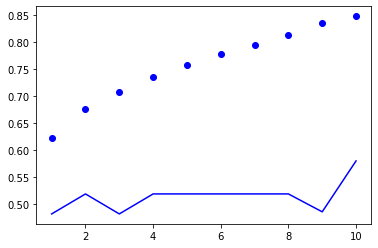

In [ ]:
history_accuracy = project_history.history["accuracy"]
history_val_accuracy = project_history.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[0.6437832713127136, 0.5973828434944153, 0.559506356716156, 0.5231662392616272, 0.495371013879776, 0.4636107385158539, 0.43574437499046326, 0.40158796310424805, 0.36782658100128174, 0.34220027923583984]
[0.6936937570571899, 0.6924636363983154, 0.6932254433631897, 0.6929081082344055, 0.7003136873245239, 0.6991862654685974, 0.7105607986450195, 0.7043150067329407, 0.692807674407959, 0.6861802339553833]


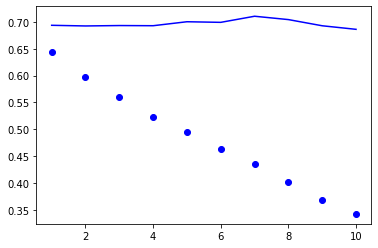

In [ ]:
history_loss = project_history.history["loss"]
history_val_loss = project_history.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

### 모델 테스트 및 예측

In [ ]:
project_test_loss, project_test_acc = project_model.evaluate(test_batches, verbose=1)

73/73 [==============================] - 5s 61ms/step - loss: 0.6863 - accuracy: 0.5860


In [ ]:
for test_batched_data in test_batches.take(1):
    target = test_batched_data[1].numpy().tolist()

    predicted = project_model.predict(test_batched_data[0])
    predicted_score = list(map(lambda in_list: in_list[0], predicted))
    predicted = list(map(lambda value: 1 if value > 0 else 0, predicted_score))
    
    print("target       : {}".format(target))
    print("predicted    : {}".format(predicted))
    print("predict score: {}".format(predicted_score))


target       : [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
predicted    : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
predict score: [0.52314454, 0.49108914, 0.51398206, 0.50870115, 0.49521568, 0.5146664, 0.5061021, 0.49286318, 0.4977654, 0.48672765, 0.5093558, 0.4928853, 0.51288015, 0.50482994, 0.49033558, 0.5017143, 0.501983, 0.5300526, 0.49906155, 0.49322423, 0.5199528, 0.5024528, 0.53136706, 0.5144934, 0.52383953, 0.5243875, 0.47590828, 0.54056174, 0.50296754, 0.5119491, 0.52617085, 0.5263169]
